Das angehängte CSV-File enthält Wärmezählerdaten (Arbeit, Leistung & Volumenstrom) sowie Temperatur-Sensordaten (insbes. die Außentemperatur) einer mit Fernwärme versorgten Heizungsanlage.

Die Aufgabe besteht darin, Lastprofile (Leistung gegen Zeit) über den Zeitraum eines Tages zu erstellen.

Es sollen die folgenden Fragen beantwortet werden:
1. Gibt es einen Unterschied in Lastprofilen zwischen Werktagen, Samstagen und Sonn- und Feiertagen (Das Haus befindet sich in Bayern)?

    In general, load is the highest in the morning at 6:00, and sharply decreases from 6:00 til noon around 13:00, 14:00. It slowly increases until 21:00, and drops sharply around 22:00. Load on Weekdays is significantly higher than Saturdays, Sundays and Holidays around 7:00 and 8:00. Between 9:00 and 17:00, load on Weekdays are higher than Saturdays and Sundays. On Holidays, the load are quite similar to Saturdays und Sundays, but having big spikes at 12:00, 16:00, 19:00 and 21:00. Saturdays and Sundays have nearly identical energy load profile with Sundays having slightly higher load. 
    
2. Kann man aus den Daten die Heizperiode ermitteln?
    
    Heizperiode falls between start of October and end of April every year as the outside temperature decreases and the energy consumption increases, reaching their respective bottom and top on February.
    
3. Gibt es eine Nachtabsenkung während der Heizperiode?
    
    There is Nachtabsenkung as Vorlauf Temperarture 1, Rucklauf Temperature, Rucklauf 1 Temperature, Rucklauf 2 Temperature decreases by 3 - 5 degrees between 21:00 and 06:00 while the outside temperature during that time is at its lowest.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar, nearest_workday
import holidays
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [30]:
fields = ["Leistung [kW]", "Zeit", "Arbeit [MWh]"]

df = pd.read_csv("Trend-2021-09-09_08-02_30.csv", delimiter=";", usecols=fields)

In [31]:
df.rename(columns={'Leistung [kW]': 'Leistung', 
                   "Arbeit [MWh]": "Arbeit" }, inplace=True)

# Convert the "Leistung" column to float
df['Leistung'] = df['Leistung'].str.replace(',', '.').astype(float)
df['Arbeit'] = df['Arbeit'].str.replace(',', '.').astype(float)

# Convert the "Zeit" column to datetime
df['Zeit'] = pd.to_datetime(df['Zeit'], format='%d.%m.%Y %H:%M:%S')

In [35]:
# Set the index of the DataFrame to the "Zeit" column
df.set_index('Zeit', inplace=True)

In [36]:
# Filter Arbeit > 0
df = df[df['Arbeit'] > 0]

In [50]:
hourly_energy = df.resample('H')['Arbeit'].max().diff().fillna(method='bfill')*1000

In [53]:
# Resample the DataFrame to hourly intervals and average the "Leistung" column for each hour
hourly_load = df.resample('H')['Leistung'].mean()

In [59]:
bayern_holidays = holidays.country_holidays('DE', subdiv='BY', years=df.index.year.unique())

In [69]:
# holiday_mask is the same for both hourly_load and hourly_energy
holiday_mask = np.in1d(hourly_load.index.date, list(bayern_holidays.keys()))

In [70]:
weekday_load = hourly_load[hourly_load.index.weekday < 5]
mean_weekday_load = weekday_load.groupby(weekday_load.index.hour).mean()
saturday_load = hourly_load[hourly_load.index.weekday == 5]
mean_saturday_load = saturday_load.groupby(saturday_load.index.hour).mean()
sunday_load = hourly_load[hourly_load.index.weekday == 6]
mean_sunday_load = sunday_load.groupby(sunday_load.index.hour).mean()
holiday_load = hourly_load[holiday_mask]
mean_holiday_load = holiday_load.groupby(holiday_load.index.hour).mean()

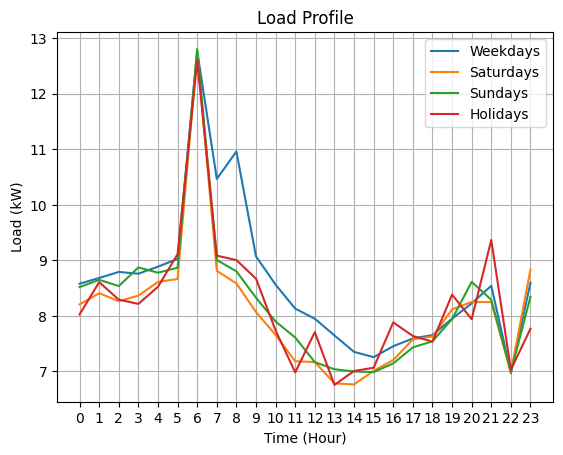

In [147]:
# Create the line graph
plt.plot(mean_weekday_load, label='Weekdays')
plt.plot(mean_saturday_load, label='Saturdays')
plt.plot(mean_sunday_load, label='Sundays')
plt.plot(mean_holiday_load, label='Holidays')

# Set the x-axis labels
plt.xticks(range(0, 24))

# Add a title and labels for the x and y axes
plt.title('Load Profile')
plt.xlabel('Time (Hour)')
plt.ylabel('Load (kW)')

# Add a legend
plt.legend()
plt.grid(True)

# Display the graph
plt.show()

In [ ]:
# # Convert the data into a long format suitable for Plotly Express
# df_plot = pd.concat([mean_weekday_load, mean_saturday_load, mean_sunday_load], axis=1)
# df_plot.columns = ['Weekday', 'Saturday', 'Sunday']
# df_plot = df_plot.reset_index().melt(id_vars='Zeit', var_name='Day Type', value_name='Energy Consumption (kW)')

# # Create the line graph with Plotly Express
# fig = px.line(df_plot, x='Zeit', y='Energy Consumption (kW)', color='Day Type')

# # Add a title and labels for the x and y axes
# fig.update_layout(title='Hourly Load Profile by Day Type', xaxis_title='Time', yaxis_title='Energy Consumption (kW)')

# # Display the graph
# fig.show()

In [146]:
# # Create a smoother line
# xnew = np.linspace(0, 23, 200)  # 300 represents number of points to make between T.min and T.max
# spl = make_interp_spline(mean_weekday_load.index, mean_weekday_load, k=3)  # type: BSpline
# power_smooth = spl(xnew)
# plt.plot(xnew, power_smooth)

# spl = make_interp_spline(mean_saturday_load.index, mean_saturday_load, k=3)  # type: BSpline
# power_smooth = spl(xnew)
# plt.plot(xnew, power_smooth)

# spl = make_interp_spline(mean_sunday_load.index, mean_sunday_load, k=3)  # type: BSpline
# power_smooth = spl(xnew)
# plt.plot(xnew, power_smooth)

# spl = make_interp_spline(mean_sunday_load.index, mean_holiday_load, k=3)  # type: BSpline
# power_smooth = spl(xnew)
# plt.plot(xnew, power_smooth)

# # Set the x-axis labels
# plt.xticks(range(0, 24))

# # Add labels to the axes
# plt.xlabel('Hour')
# plt.ylabel('Load (kW)')
# plt.title('Load Profile')

# plt.grid(True)

# # Add a legend
# plt.legend(['Weekday', 'Saturday', 'Sunday', 'Holiday'])

In [149]:
fields = ["Arbeit [MWh]", "Außentemperatur [°C]", "Zeit"]

df = pd.read_csv("Trend-2021-09-09_08-02_30.csv", delimiter=";", usecols=fields)

In [150]:
df.rename(columns={'Arbeit [MWh]': 'Arbeit', 'Außentemperatur [°C]': 'Außentemperatur'}, inplace=True)

# Convert the "Leistung" column to float
df['Arbeit'] = df['Arbeit'].str.replace(',', '.').astype(float)

# Convert the "Außentemperatur" column to float
df['Außentemperatur'] = df['Außentemperatur'].str.replace(',', '.').astype(float)

# Convert the "Zeit" column to datetime
df['Zeit'] = pd.to_datetime(df['Zeit'], format='%d.%m.%Y %H:%M:%S')

# Set the index of the DataFrame to the "Zeit" column
df.set_index('Zeit', inplace=True)

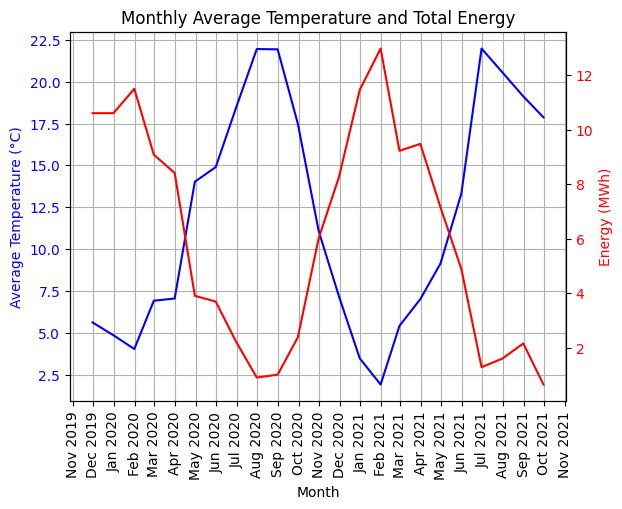

In [153]:
# Create figure and axes objects
fig, ax1 = plt.subplots()

# Group the DataFrame by the month and calculate the mean of the 'Außentemperatur' column
monthly_temp = df.groupby(pd.Grouper(freq='M'))['Außentemperatur'].mean()

# Plot the data on the first axis
ax1.plot(monthly_temp, color='blue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Temperature (°C)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Monthly Average Temperature and Total Energy')

plt.xticks(rotation=90)

# Add a second axis for the energy data
ax2 = ax1.twinx()

# Group the DataFrame by the month and calculate the mean of the 'Leistung' column
monthly_energy = df.groupby(pd.Grouper(freq='M'))['Arbeit'].max().diff().fillna(method='bfill')

# Plot the data on the second axis
ax2.plot(monthly_energy, color='red')
ax2.set_ylabel('Energy (MWh)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add x-axis ticks for all months
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.grid(True)

plt.show()

In [134]:
# # Get data between the first of October and the end of April every year
# heating_season_mask = ((hourly_load.index.month >= 10) | (hourly_load.index.month <= 4))
# heating_season_load = hourly_load[heating_season_mask]
# heating_season_holiday_mask = np.in1d(heating_season_load.index.date, list(bayern_holidays.keys()))

In [135]:
# heating_season_weekday_load = heating_season_load[heating_season_load.index.weekday < 5]
# heating_season_mean_weekday_load = heating_season_weekday_load.groupby(heating_season_weekday_load.index.hour).mean()
# heating_season_saturday_load = heating_season_load[heating_season_load.index.weekday == 5]
# heating_season_mean_saturday_load = heating_season_saturday_load.groupby(heating_season_saturday_load.index.hour).mean()
# heating_season_sunday_load = heating_season_load[heating_season_load.index.weekday == 6]
# heating_season_mean_sunday_load = heating_season_sunday_load.groupby(heating_season_sunday_load.index.hour).mean()
# heating_season_holiday_load = heating_season_load[heating_season_holiday_mask]
# heating_season_mean_holiday_load = heating_season_holiday_load.groupby(heating_season_holiday_load.index.hour).mean()

In [137]:
# # Create the line graph
# plt.plot(heating_season_mean_weekday_load, label='Weekday')
# plt.plot(heating_season_mean_saturday_load, label='Saturday')
# plt.plot(heating_season_mean_sunday_load, label='Sunday')
# plt.plot(heating_season_mean_holiday_load, label='Holiday')

# # Set the x-axis labels
# plt.xticks(range(0, 24))

# # Add a title and labels for the x and y axes
# plt.title('Hourly Load Profile by Day Type')
# plt.xlabel('Time (hours)')
# plt.ylabel('Energy Consumption (kW)')

# # Add a legend
# plt.legend()

# plt.grid(True)

# # Display the graph
# plt.show()

In [ ]:
# # Get data between the first of October and the end of April every year
# non_heating_season_mask = ((hourly_load.index.month < 10) & (hourly_load.index.month > 4))
# non_heating_season_load = hourly_load[non_heating_season_mask]
# non_heating_season_holiday_mask = np.in1d(non_heating_season_load.index.date, list(bayern_holidays.keys()))

In [ ]:
# non_heating_season_weekday_load = non_heating_season_load[non_heating_season_load.index.weekday < 5]
# non_heating_season_mean_weekday_load = non_heating_season_weekday_load.groupby(non_heating_season_weekday_load.index.hour).mean()
# non_heating_season_saturday_load = non_heating_season_load[non_heating_season_load.index.weekday == 5]
# non_heating_season_mean_saturday_load = non_heating_season_saturday_load.groupby(non_heating_season_saturday_load.index.hour).mean()
# non_heating_season_sunday_load = non_heating_season_load[non_heating_season_load.index.weekday == 6]
# non_heating_season_mean_sunday_load = non_heating_season_sunday_load.groupby(non_heating_season_sunday_load.index.hour).mean()
# non_heating_season_holiday_load = non_heating_season_load[non_heating_season_holiday_mask]
# non_heating_season_mean_holiday_load = non_heating_season_holiday_load.groupby(non_heating_season_holiday_load.index.hour).mean()

In [138]:
# # Create the line graph
# plt.plot(non_heating_season_mean_weekday_load, label='Weekday')
# plt.plot(non_heating_season_mean_saturday_load, label='Saturday')
# plt.plot(non_heating_season_mean_sunday_load, label='Sunday')
# plt.plot(non_heating_season_mean_holiday_load, label='Holiday')

# # Set the x-axis labels
# plt.xticks(range(0, 24))

# # Add a title and labels for the x and y axes
# plt.title('Hourly Load Profile by Day Type')
# plt.xlabel('Time (hours)')
# plt.ylabel('Energy Consumption (kW)')

# # Add a legend
# plt.legend()

# plt.grid(True)

# # Display the graph
# plt.show()

In [139]:
fields = ["Leistung [kW]", "Außentemperatur [°C]", "Zeit", "Prim. Vorlauf [°C]",
         "Prim. Rücklauf [°C]", "Rücklauf 1 [°C]", "Rücklauf 2 [°C]", "Vorlauf 1 [°C]"]

df = pd.read_csv("Trend-2021-09-09_08-02_30.csv", delimiter=";", usecols=fields)

In [140]:
df.rename(columns={'Leistung [kW]': 'Leistung', 'Außentemperatur [°C]': 'Außentemperatur', 
                  "Prim. Vorlauf [°C]": "Prim. Vorlauf", 
                  "Prim. Rücklauf [°C]": "Prim. Rücklauf", 
                  "Rücklauf 1 [°C]": "Rücklauf 1", 
                  "Rücklauf 2 [°C]": "Rücklauf 2", 
                  "Vorlauf 1 [°C]": "Vorlauf 1"}, inplace=True)

In [141]:
# Convert the "Leistung", "Außentemperatur" column to float
df['Leistung'] = df['Leistung'].str.replace(',', '.').astype(float)
df['Außentemperatur'] = df['Außentemperatur'].str.replace(',', '.').astype(float)
df['Rücklauf 1'] = df['Rücklauf 1'].str.replace(',', '.').astype(float)
df['Rücklauf 2'] = df['Rücklauf 2'].str.replace(',', '.').astype(float)
df['Vorlauf 1'] = df['Vorlauf 1'].str.replace(',', '.').astype(float)

# Convert the "Zeit" column to datetime
df['Zeit'] = pd.to_datetime(df['Zeit'], format='%d.%m.%Y %H:%M:%S')
df.set_index('Zeit', inplace=True)

In [142]:
df = df.loc[(df.index.month >= 10) | (df.index.month <= 4)]

In [143]:
# Resample the DataFrame to hourly intervals
hourly_data = df.resample('H').mean()

In [144]:
mean_vorlauf_temp = hourly_data['Prim. Vorlauf'].groupby(hourly_data.index.hour).mean()
mean_rucklauf_temp = hourly_data['Prim. Rücklauf'].groupby(hourly_data.index.hour).mean()
mean_outside_temp = hourly_data['Außentemperatur'].groupby(hourly_data.index.hour).mean()
mean_rucklauf_1_temp = hourly_data['Rücklauf 1'].groupby(hourly_data.index.hour).mean()
mean_rucklauf_2_temp = hourly_data['Rücklauf 2'].groupby(hourly_data.index.hour).mean()
mean_vorlauf_1_temp = hourly_data['Vorlauf 1'].groupby(hourly_data.index.hour).mean()

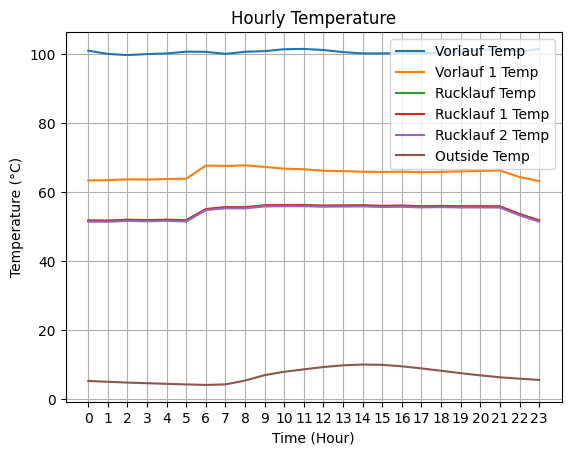

In [161]:
# Create the line graph
plt.plot(mean_vorlauf_temp, label='Vorlauf Temp')
plt.plot(mean_vorlauf_1_temp, label='Vorlauf 1 Temp')
plt.plot(mean_rucklauf_temp, label='Rucklauf Temp')
plt.plot(mean_rucklauf_1_temp, label='Rucklauf 1 Temp')
plt.plot(mean_rucklauf_2_temp, label='Rucklauf 2 Temp')
plt.plot(mean_outside_temp, label='Outside Temp')

# Set the x-axis labels
plt.xticks(range(0, 24))

# Add a title and labels for the x and y axes
plt.title('Hourly Temperature')
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (°C)')

# Add a legend
plt.legend()

plt.grid(True)

# Display the graph
plt.show()